#### File used to compare the losses used in DEEPLAB:
1. Cross Entropy
2. 0.5 * Cross Entropy +  0.5* Lovász-Softmax

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

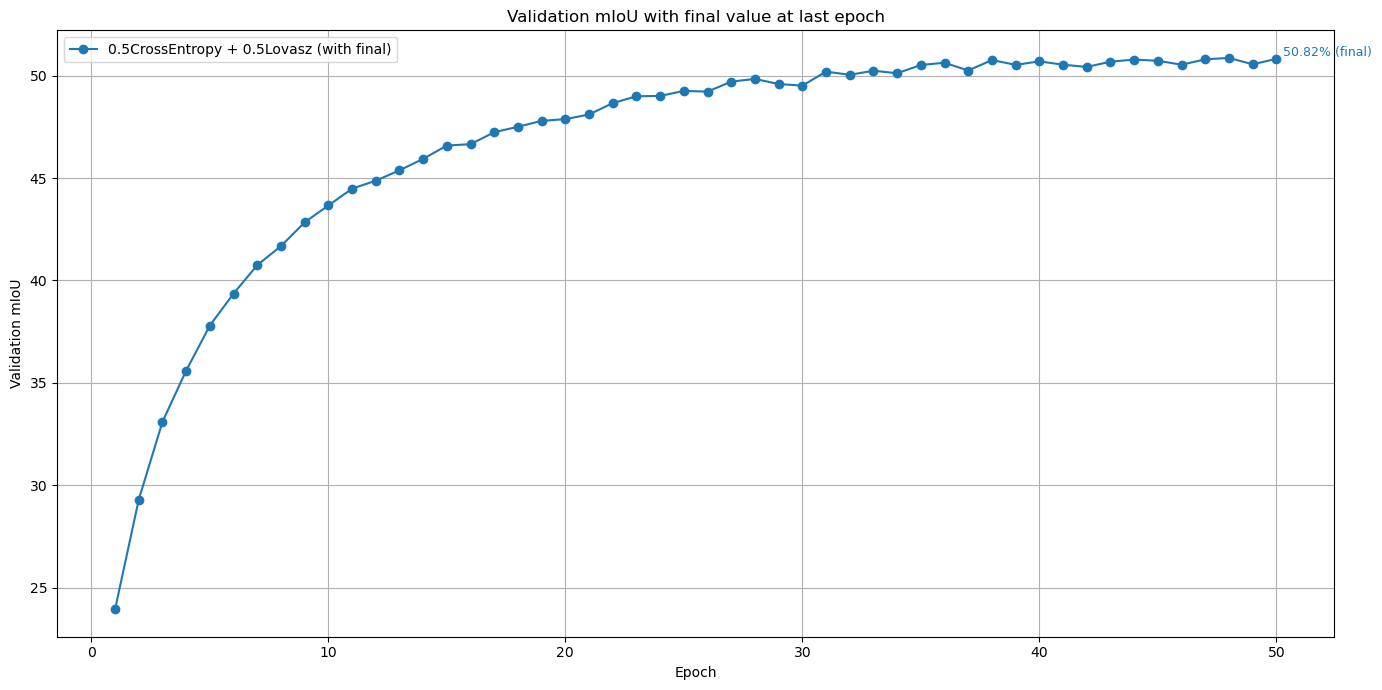

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("wandb_export_2025-05-15T16_12_48.823+02_00.csv")

ce_05lovasz_miou = df[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
final_row = df[['epoch', 'val_mIoU_final']].dropna().sort_values(by='epoch').iloc[-1]

max_epoch = ce_05lovasz_miou['epoch'].max()

# Se l'ultimo epoch in val_mIoU è < final_row['epoch'], aggiungo punto finale
if max_epoch < final_row['epoch']:
    final_point = pd.DataFrame([{
        'epoch': final_row['epoch'],
        'val_mIoU': final_row['val_mIoU_final'],
    }])
    ce_extended = pd.concat([ce_05lovasz_miou, final_point], ignore_index=True)
else:
    # Altrimenti aggiorno il valore dell'ultima epoca
    ce_extended = ce_05lovasz_miou.copy()
    last_idx = ce_extended['epoch'].idxmax()
    ce_extended.loc[last_idx, 'val_mIoU'] = final_row['val_mIoU_final']

plt.figure(figsize=(14,7))
line_ce, = plt.plot(ce_extended['epoch'], ce_extended['val_mIoU'],
                    label='0.5CrossEntropy + 0.5Lovasz (with final)', linestyle='-', marker='o')

plt.text(final_row['epoch'] + 0.3, final_row['val_mIoU_final'],
         f"{final_row['val_mIoU_final']:.2f}% (final)",
         color=line_ce.get_color(), ha='left', va='bottom', fontsize=9)

plt.xlabel('Epoch')
plt.ylabel('Validation mIoU')
plt.title('Validation mIoU with final value at last epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import matplotlib.pyplot as plt

results = []

def process_single_df(df, label):
    df_clean = ce_extended.copy()
    if df_clean.empty:
        print(f"Warning: DataFrame '{label}' empty after dropna.")
        return

    total_runtime_min = df_clean['Runtime'].sum() / 60

    epoch_50_row = df_clean[df_clean['epoch'] == 50]
    if not epoch_50_row.empty:
        val_miou_final_50 = epoch_50_row.iloc[0].get('val_mIoU_final', None)
        if pd.notna(val_miou_final_50):
            print(f"Warning: Found 'val_mIoU_final' for epoch 50 in DataFrame '{label}'.")
            final_miou = val_miou_final_50
            print(f"Final mIoU for epoch 50: {final_miou}")
        else:
            final_miou = epoch_50_row.iloc[0]['val_mIoU']
    else:
        final_miou = df_clean.iloc[-1]['val_mIoU']

    results.append({'label': label, 'miou': final_miou, 'runtime': total_runtime_min})

# Usa la funzione con l’etichetta specificata
process_single_df(ce_extended, '0.5CE + 0.5Lovasz')

# Estrai dati e plotta
runtimes = [r['runtime'] for r in results]
mious = [r['miou'] for r in results]
labels = [r['label'] for r in results]

plt.figure(figsize=(10,6))
plt.scatter(runtimes, mious, color='blue')

offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5
offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05

for i, label in enumerate(labels):
    plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
             f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%",
             fontsize=9, ha='left', va='bottom')

plt.xlabel('Total Training Time (minutes)')
plt.ylabel('Final Validation mIoU (%)')
plt.title('Trade-off: mIoU vs. Total Training Time')
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Runtime'